In [1]:
from ipywidgets import interact
from fastai.basics import *
from fastai.vision.all import *
matplotlib.rc('image', cmap='Greys')

### Manual Parameter Tuning

At its core, deep learning seeks to produce a mathematical function that most closely approximates the values we expect in a given situation.

For example, we can construct a quadratic function with known parameters a,b,c and plot it, then make another quadratic starting with random values for parameters a,b,c and blindly tinker with their values until you hit the closest match. You can do this visually or with a loss function which tells us how close we are, mean squared error in this case.


In [35]:
def quadratic(x: Tensor, params: Tensor):
    a, b, c = params
    return a * x ** 2 + b * x + c


def make_quadratic(params: Tensor):
    return partial(quadratic, params=params)


def mean_squared_error(actual: Tensor, tinker: Tensor):
    return ((tinker - actual) ** 2).mean()


original_params = torch.tensor([3.0, 2.0, 1.0])
quad = make_quadratic(params=original_params)

times = torch.arange(-10, 10).float()


@interact(a=1.1, b=1.1, c=1.1)
def plot_quadratic(a: float, b: float, c: float):
    plt.figure()
    plt.plot(times, quad(times))
    tinker_quad = make_quadratic(params=torch.tensor([a, b, c]))
    plt.title(
        f"MSE {round(mean_squared_error(quad(times), tinker_quad(times)).item(), 2)}"
    )
    plt.plot(times, tinker_quad(times))


interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

### Automated Parameter Tuning

This is basically what a deep learning model does, except we systematize the guesses to do it extremely quickly. We can use gradients to determine which direction, and relatively how much, we should move each parameter.

Here, we create a set of random initial training parameters with gradient calculation enabled. Then, we go through the training cycle:

1. Calculate the prediction based on our params
2. Calculate the loss on this prediction
3. Calculate the gradients on these parameters
4. Adjust our parameters based on the gardients times the learning rate
5. Repeat


tensor(2558.5718, grad_fn=<MeanBackward0>)
tensor(21.5210, grad_fn=<MeanBackward0>)
tensor(8.5803, grad_fn=<MeanBackward0>)
tensor(4.9863, grad_fn=<MeanBackward0>)
tensor(3.9549, grad_fn=<MeanBackward0>)
tensor(3.6265, grad_fn=<MeanBackward0>)
tensor(3.4917, grad_fn=<MeanBackward0>)
tensor(3.4107, grad_fn=<MeanBackward0>)
tensor(3.3453, grad_fn=<MeanBackward0>)
tensor(3.2848, grad_fn=<MeanBackward0>)


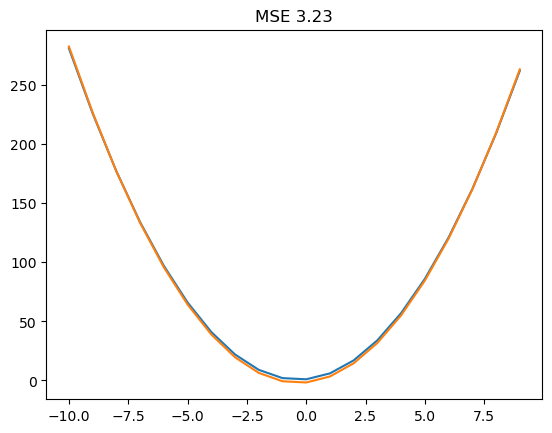

In [17]:
def quadratic(x: Tensor, params: Tensor):
    a, b, c = params
    return a * x ** 2 + b * x + c


def mean_squared_error(actual: Tensor, prediction: Tensor):
    return ((prediction - actual) ** 2).mean()


times = torch.arange(-10, 10).float()

actual_params = torch.tensor([3.0, 2.0, 1.0])
actual = quadratic(times, actual_params)
training_params = torch.randn(3, requires_grad=True)

learning_rate = 0.0001

for i in range(1000):
    prediction = quadratic(times, training_params)
    loss = mean_squared_error(actual, prediction)
    if i % 100 == 0:
        print(loss)
    loss.backward()  # AKA calculate gradient
    training_params.data -= training_params.grad.data * learning_rate  # type: ignore (pylance doesn't understand loss.backward was called)
    # Note grad has to be reset or it accumulates between cycles and produces incorrect data
    training_params.grad = None

plt.figure()
plt.plot(times, actual)
plt.title(f"MSE {round(mean_squared_error(actual, prediction).item(), 2)}")
# Note these will be so close together they may be overlapping/second invisble
plt.plot(times, prediction.detach().numpy())


### Calculating Gradients

The last piece to understand here is how we calculate the gradients.

The gradients are based on the **derivative of the loss function with respect to each variable**.

To calculate the derivative of a multivariate function, we take the partial derivative of the loss function for each variable, holding the remainder constant.

Below is an example of getting the derivative of the loss function with respect to a, holding b and c constant. Note that the quadratic function and the loss function both appear the same on a graph because they are both quadratic formulae, but they are separate graphs. The function has x of time and y of speed, while the loss function has x of paramater value and y of loss.

Here we are getting every loss within a range of values of the paramater a, then plotting the minimum.

Ultimately, all the gradient is doing is taking the partial derivative with respect to each variable, holding the others constant. It tells you which way to move each and approximately how much based on this.


Text(0.5, 1.0, 'Loss function with min loss at: (3, 0.0)')

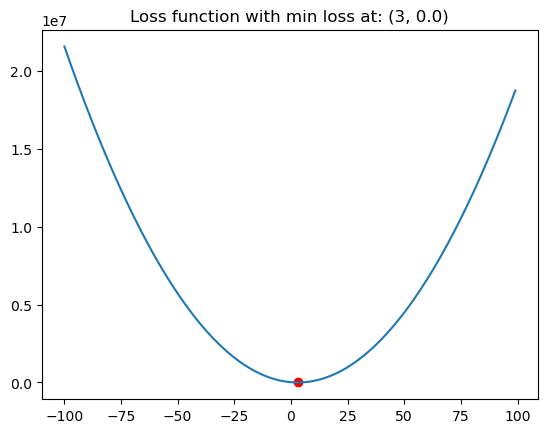

In [5]:
times = torch.arange(-10, 10).float()


def quadratic(x: Tensor, params: Tensor):
    a, b, c = params
    return a * x ** 2 + b * x + c


def mean_squared_error(actual: Tensor, training_params: Tensor):
    prediction = quadratic(times, training_params)
    return ((prediction - actual) ** 2).mean()


actual_params = torch.tensor([3.0, 2.0, 1.0])
actual = quadratic(times, actual_params)

times = torch.arange(-10, 10).float()

learning_rate = 0.0001

losses = []

parameter_a_tests = range(-100, 100)

for parameter_a in parameter_a_tests:
    losses.append(
        mean_squared_error(actual, torch.tensor([float(parameter_a), 2.0, 1.0]))
    )

min_loss_idx = np.argmin(losses)

plt.figure()
plt.plot(parameter_a_tests, losses)
plt.scatter(parameter_a_tests[min_loss_idx], losses[min_loss_idx], color="red")
plt.plot()
plt.title(
    f"Loss function with min loss at: {parameter_a_tests[min_loss_idx], losses[min_loss_idx].item()}"
)


### Rectified Linear Units

A rectified linear unit is very simply just taking a linear function and clamping the negative values to zero.


In [20]:
def rectified_linear(x: Tensor, params: Tensor):
    m, b = params
    y = m * x + b
    # aka clamp clamp < 0 to 0
    return torch.clip(y, 0.0)


x = torch.linspace(-2.1, 2.1, 100)


@interact(m=1.5, b=1.5)
def plot_rectified_linear(m: float, b: float):
    plt.figure()
    plt.plot(x, rectified_linear(x, torch.tensor([m, b])))
    plt.title(f"Rectified Linear")


interactive(children=(FloatSlider(value=1.5, description='m', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

Rectified linear units are useful, as opposted to plain linear functions, because they can be meaningfully combined.

**If you just combine two linear functions, the result will always be another linear function.** So, if you are estimating anything except linear functions, this isn't useful.

However, if you combine rectified linear units, you can chain them together to produce different shapes.


In [29]:
def double_rectified_linear(x: Tensor, params: Tensor):
    m1, b1, m2, b2 = params
    y1 = torch.clip(m1 * x + b1, 0)
    y2 = torch.clip(m2 * x + b2, 0)
    return y1 + y2


@interact(m1=-1.5, b1=-1.5, m2=1.5, b2=1.5)
def plot_double_rectified_linear(m1: float, b1: float, m2: float, b2: float):
    plt.figure()
    plt.plot(x, double_rectified_linear(x, torch.tensor([m1, b1, m2, b2])))
    plt.title(f"Double Rectified Linear")


interactive(children=(FloatSlider(value=-1.5, description='m1', max=1.5, min=-4.5), FloatSlider(value=-1.5, de…

Despite being so simple, the beauty of combining rectified linear functions is that, with enough of them added together, **you could approximate any function with a single input, to whatever accuracy you like!** Any time a function doesn't quite match, just add a few more additions to the mix to make it a bit closer.


In [85]:
def mean_squared_error(actual: Tensor, tinker: Tensor):
    return ((tinker - actual) ** 2).mean()


def quadruple_rectified_linear(x: Tensor, params: Tensor):
    m1, b1, m2, b2, m3, b3, m4, b4 = params
    y1 = torch.clip(m1 * x + b1, 0)
    y2 = torch.clip(m2 * x + b2, 0)
    y3 = torch.clip(m3 * x + b3, 0)
    y4 = torch.clip(m4 * x + b4, 0)
    return y1 + y2 + y3 + y4


@interact(m1=-1.5, b1=-1.5, m2=1.5, b2=1.5, m3=1.1, b3=1.1, m4=-0.2, b4=-0.2)
def plot_quadruple_rectified_linear(
    m1: float,
    b1: float,
    m2: float,
    b2: float,
    m3: float,
    b3: float,
    m4: float,
    b4: float,
):
    plt.figure()
    quad_relu = quadruple_rectified_linear(
        x, torch.tensor([m1, b1, m2, b2, m3, b3, m4, b4])
    )
    plt.plot(x, quad_relu)
    quad = quadratic(x, torch.tensor([3, 2, 1]))
    plt.plot(x, quad)
    plt.title(
        f"Quadruple Rectified Linear\nApproximating Quadratic\nMean Squared Error: {mean_squared_error(quad, quad_relu)}"
    )


interactive(children=(FloatSlider(value=-1.5, description='m1', max=1.5, min=-4.5), FloatSlider(value=-1.5, de…

tensor(44.4703, grad_fn=<MeanBackward0>)
tensor(0.7804, grad_fn=<MeanBackward0>)
tensor(0.5327, grad_fn=<MeanBackward0>)
tensor(0.4747, grad_fn=<MeanBackward0>)
tensor(0.4576, grad_fn=<MeanBackward0>)
tensor(0.4461, grad_fn=<MeanBackward0>)
tensor(0.4407, grad_fn=<MeanBackward0>)
tensor(0.4372, grad_fn=<MeanBackward0>)
tensor(0.4345, grad_fn=<MeanBackward0>)
tensor(0.4322, grad_fn=<MeanBackward0>)


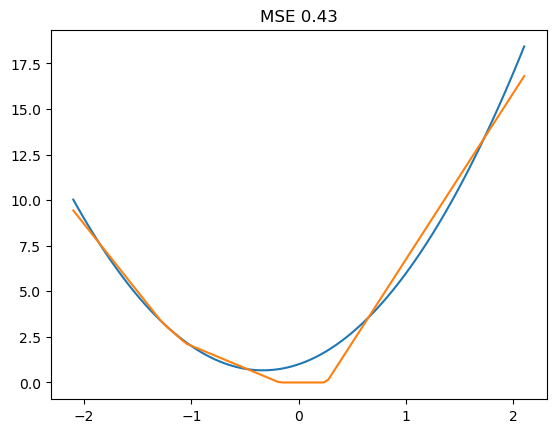

In [43]:
actual = quadratic(x, torch.tensor([3.0, 2.0, 1.0]))
training_params = torch.randn(8, requires_grad=True)

learning_rate = 0.001

for i in range(100000):
    prediction = quadruple_rectified_linear(x, training_params)
    loss = mean_squared_error(actual, prediction)
    if i % 10000 == 0:
        print(loss)
    loss.backward()  # AKA calculate gradient
    training_params.data -= training_params.grad.data * learning_rate  # type: ignore (pylance doesn't understand loss.backward was called)
    # Note grad has to be reset or it accumulates between cycles and produces incorrect data
    training_params.grad = None

plt.figure()
plt.plot(x, actual)
plt.title(f"MSE {round(mean_squared_error(actual, prediction).item(), 2)}")
plt.plot(x, prediction.detach().numpy())


We could keep increasing the fidelity of our predictions by adding more rectified linears. If we go up to something like a 40-layered rectified linear, we can predict a **quadratic** equation within a small percentage using **rectified linear** equations layered together.


In [4]:
from itertools import islice
from typing import Iterable, Any

# https://docs.python.org/3/library/itertools.html#itertools.zip_longest
def grouper(iterable, n, *, incomplete="fill", fillvalue=None):
    "Collect data into non-overlapping fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, fillvalue='x') --> ABC DEF Gxx
    # grouper('ABCDEFG', 3, incomplete='strict') --> ABC DEF ValueError
    # grouper('ABCDEFG', 3, incomplete='ignore') --> ABC DEF
    args = [iter(iterable)] * n
    if incomplete == "fill":
        return zip_longest(*args, fillvalue=fillvalue)
    if incomplete == "strict":
        return zip(*args, strict=True)
    if incomplete == "ignore":
        return zip(*args)
    else:
        raise ValueError("Expected fill, strict, or ignore")


def n_rectified_linear(x: Tensor, params: Tensor):
    rectified_linears = [
        torch.clip(linear_params[0] * x + linear_params[1], 0)
        for linear_params in grouper(params, 2, incomplete="ignore")
    ]
    return reduce(add, rectified_linears)


actual = quadratic(x, torch.tensor([3.0, 2.0, 1.0]))
training_params = torch.randn(80, requires_grad=True)

learning_rate = 0.001

for i in range(10000):
    prediction = n_rectified_linear(x, training_params)
    loss = mean_squared_error(actual, prediction)
    if i % 1000 == 0:
        print(loss)
    loss.backward()  # AKA calculate gradient
    training_params.data -= training_params.grad.data * learning_rate  # type: ignore (pylance doesn't understand loss.backward was called)
    # Note grad has to be reset or it accumulates between cycles and produces incorrect data
    training_params.grad = None

plt.figure()
plt.plot(x, actual)
plt.title(f"MSE {round(mean_squared_error(actual, prediction).item(), 2)}")
plt.plot(x, prediction.detach().numpy())


NameError: name 'quadratic' is not defined

We were already able to perfectly predict a quadratic equation by manipulating the inputs of the quadratic from unknowns, so how is this helpful?

That is of limited use because we substantially limited the universe of possibilities - we already made the assumption it was a quadratic, we just needed the parameters. If we had instead been predicting a sine wave, the quadratic input manipulation would have been useless.

The beauty of combining rectified linear units is that it is **universally applicable**. The shape of the curve doesn't matter, we can predict anything with enough rectified linears.


In [206]:
import torch.nn as nn
from typing import Callable

def mean_squared_error(actual: Tensor, tinker: Tensor):
    return ((tinker - actual) ** 2).mean()

def n_rectified_linear(x: Tensor, params: Tensor):
    rectified_linears = [
        torch.clip(linear_params[0] * x + linear_params[1], 0)
        for linear_params in grouper(params, 2, incomplete="ignore")
    ]
    return reduce(add, rectified_linears)

def train_model(
    input: Tensor,
    labels: Tensor,
    loss_function: Callable[[Tensor, Tensor], Tensor],
    learning_rate: float = 0.0001,
    epochs: int = 1000
):
    training_params = torch.randn(90, requires_grad=True)

    for i in range(epochs):
        prediction = n_rectified_linear(input, training_params)
        # loss = mean_squared_error(labels, prediction)
        loss = loss_function(labels, prediction)
        if i % 100 == 0 or i == 0:
            print(loss)
            # plt.title(f"MSE {round(loss.item(), 3)}")
            # plt.plot(x, actual)
            # plt.plot(x, prediction.detach().numpy())
            # plt.pause(0.01)
        # if i % 1000 == 0:
        #     learning_rate = learning_rate / 1.5
        loss.backward()  # AKA calculate gradient
        training_params.data -= training_params.grad.data * learning_rate  # type: ignore (pylance doesn't understand loss.backward was called)
        # Note grad has to be reset or it accumulates between cycles and produces incorrect data
        training_params.grad = None

    return prediction


tensor(6251.5776, grad_fn=<MeanBackward0>)
tensor(671.9824, grad_fn=<MeanBackward0>)
tensor(767.6995, grad_fn=<MeanBackward0>)
tensor(559.4589, grad_fn=<MeanBackward0>)
tensor(526.4018, grad_fn=<MeanBackward0>)
tensor(550.9539, grad_fn=<MeanBackward0>)
tensor(490.5375, grad_fn=<MeanBackward0>)
tensor(486.2121, grad_fn=<MeanBackward0>)
tensor(527.5562, grad_fn=<MeanBackward0>)
tensor(503.6173, grad_fn=<MeanBackward0>)


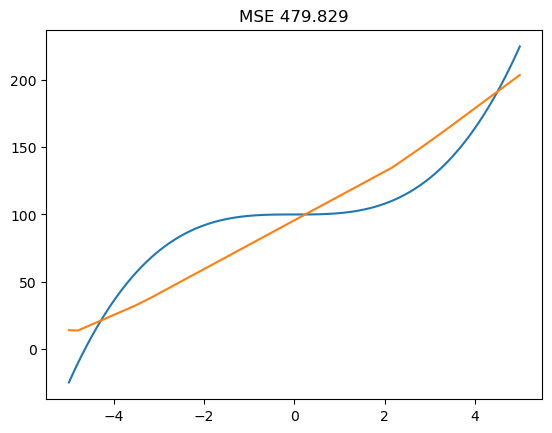

In [208]:
x = torch.linspace(-5, 5, 100)
# actual = torch.sigmoid(x)
# actual = torch.sin(x)
# actual = quadratic(x, torch.tensor([-3.0, 2.0, 1.0])) + 100
actual = x**3 + 100

loss_function = mean_squared_error
prediction = train_model(x, actual, mean_squared_error, 0.01, 1000)
# prediction = train_model(x, actual, loss_function, 0.01, 1000)

plt.plot(x, actual)
plt.title(f"MSE {round(loss_function(actual, prediction).item(), 3)}")
plt.plot(x, prediction.detach().numpy())

One consideration to make when using neural networks is the domain space of the output. Because of how they work (always positive, so layering them can only make them more positive), rectified linears are incapable of bending downward except before the first upturn.

So, when we are solving for anything other than a positive quadratic, ReLUs need to be adjusted in the output layer. Technically, the output layer is actually very similar to a hidden layer - you use a linear equation $y = wx + b$ to use weights and a bias to adjust the output. It can also use a function to adjust the domain of the output.

When we solved the original positive quadratic with ReLUs, we were implicitly using a constant weight of 1 and a bias of 0, with no function to adjust the output domain. All we need to do to allow ReLUs to solve other equations is to add a weight and bias to the parameters of the output of each hidden layer - this allows the numbers to grow either negative or positive, since the weights and biases can be negative. Since the output domain is unbounded (any real number), we don't need to apply a function. If we wanted a result like 0-1 (as we often do in real ML) we could use, for example, sigmoid to bound there results to 0-1.

In [2]:
from itertools import islice

# https://docs.python.org/3/library/itertools.html#itertools.zip_longest
def grouper(iterable, n, *, incomplete="fill", fillvalue=None):
    "Collect data into non-overlapping fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, fillvalue='x') --> ABC DEF Gxx
    # grouper('ABCDEFG', 3, incomplete='strict') --> ABC DEF ValueError
    # grouper('ABCDEFG', 3, incomplete='ignore') --> ABC DEF
    args = [iter(iterable)] * n
    if incomplete == "fill":
        return zip_longest(*args, fillvalue=fillvalue)
    if incomplete == "strict":
        return zip(*args, strict=True)
    if incomplete == "ignore":
        return zip(*args)
    else:
        raise ValueError("Expected fill, strict, or ignore")

In [5]:
from math import isnan
import torch.nn as nn
from typing import Callable
from typing import Iterable, Any


def mean_squared_error(actual: Tensor, tinker: Tensor):
    return ((tinker - actual) ** 2).mean()

# param 0 is input weight, param 1 is input bias, param 2 is output weight, 3 is output bias 
def n_rectified_linear_weighted_ouput(x: Tensor, params: Tensor):
    rectified_linears = [
        torch.clip(linear_params[0] * x + linear_params[1], 0) * linear_params[2]
        for linear_params in grouper(params, 4, incomplete="ignore")
    ]
    return reduce(add, rectified_linears) + params[-1]


def train_model(
    input: Tensor,
    labels: Tensor,
    hidden_neurons: int,
    loss_function: Callable[[Tensor, Tensor], Tensor],
    learning_rate: float = 0.0001,
    epochs: int = 1000
):
    training_params = torch.randn(hidden_neurons * 4, requires_grad=True)

    for i in range(epochs):
        prediction = n_rectified_linear_weighted_ouput(input, training_params)
        # loss = mean_squared_error(labels, prediction)
        loss = loss_function(labels, prediction)
        # If we overshoot with too high a learning rate, loss quickly goes to nan
        if torch.isnan(loss):
            print('nan loss', loss)
            print('on epoch', i)
        if i % 1000 == 0 or i == 0:
            print(loss)
        # if i % 1000 == 0:
        #     learning_rate = learning_rate / 1.5
        loss.backward()  # AKA calculate gradient
        training_params.data -= training_params.grad.data * learning_rate  # type: ignore (pylance doesn't understand loss.backward was called)
        # Note grad has to be reset or it accumulates between cycles and produces incorrect data
        training_params.grad = None

    return prediction


tensor(13011.8271, grad_fn=<MeanBackward0>)
tensor(252.1915, grad_fn=<MeanBackward0>)
tensor(155.1994, grad_fn=<MeanBackward0>)
tensor(110.0408, grad_fn=<MeanBackward0>)
tensor(83.7749, grad_fn=<MeanBackward0>)
tensor(66.4969, grad_fn=<MeanBackward0>)
tensor(53.1590, grad_fn=<MeanBackward0>)
tensor(42.3260, grad_fn=<MeanBackward0>)
tensor(34.7255, grad_fn=<MeanBackward0>)
tensor(29.0620, grad_fn=<MeanBackward0>)


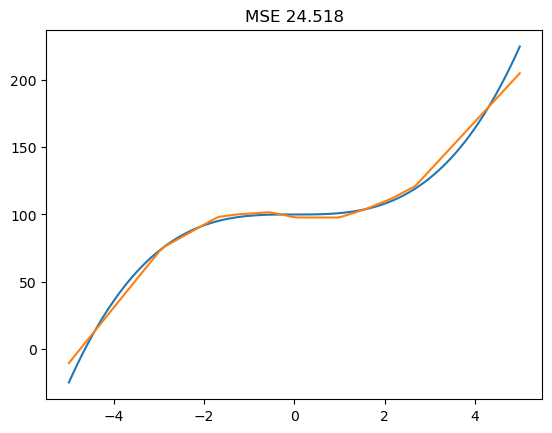

In [6]:
x = torch.linspace(-5, 5, 100)
# actual = torch.sigmoid(x)
# actual = torch.sin(x)
# actual = quadratic(x, torch.tensor([-3.0, 2.0, 1.0])) + 100
actual = x**3 + 100

loss_function = mean_squared_error
prediction = train_model(x, actual, 20, mean_squared_error, 0.0001, 10000)
# prediction = train_model(x, actual, loss_function, 0.01, 1000)

plt.plot(x, actual)
plt.title(f"MSE {round(loss_function(actual, prediction).item(), 3)}")
plt.plot(x, prediction.detach().numpy())

tensor(131.7840, grad_fn=<MeanBackward0>)
tensor(0.0608, grad_fn=<MeanBackward0>)
tensor(0.0263, grad_fn=<MeanBackward0>)
tensor(0.0213, grad_fn=<MeanBackward0>)
tensor(0.0176, grad_fn=<MeanBackward0>)
tensor(0.0150, grad_fn=<MeanBackward0>)
tensor(0.0131, grad_fn=<MeanBackward0>)
tensor(0.0117, grad_fn=<MeanBackward0>)
tensor(0.0106, grad_fn=<MeanBackward0>)
tensor(0.0098, grad_fn=<MeanBackward0>)


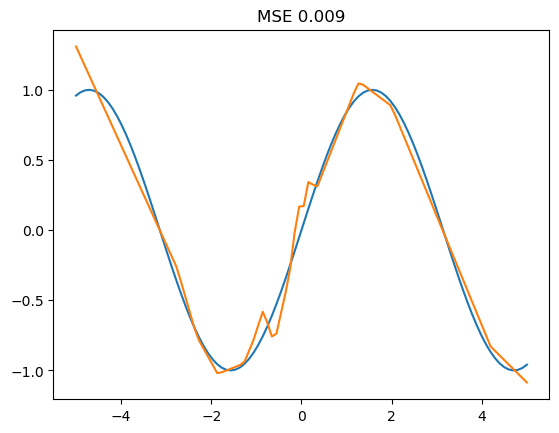

In [7]:
x = torch.linspace(-5, 5, 100)
# actual = torch.sigmoid(x)
actual = torch.sin(x)
# actual = quadratic(x, torch.tensor([-3.0, 2.0, 1.0])) + 100
# actual = x**3 + 100

loss_function = mean_squared_error
prediction = train_model(x, actual, 40, mean_squared_error, 0.001, 10000)
# prediction = train_model(x, actual, loss_function, 0.01, 1000)

plt.plot(x, actual)
plt.title(f"MSE {round(loss_function(actual, prediction).item(), 3)}")
plt.plot(x, prediction.detach().numpy())

#### Updating n_relu with matrix multiplication and mini-batches

What I did above with n_rectified_linears is ultimately correct but a sloppy first attempt that doesn't translate well into the typical neural network language.

The below is a vast simplification which does the exact same thing, but is much more efficient, and can be directly converted to pytorch/fastai native code.

The two biggest differences of note here:
* Matrix multiplication is used rather than individual multiplication, then the reduce function.
* Because matrix multiplication is used, I needed to reshape the data using unsqueeze. http://matrixmultiplication.xyz/
* Although the result is the same, the resulting neural architecture I had essentially stumbled into was very unclear. Here, it is very straightforward - 1 input neuron, x hidden neurons (modifiable) in 1 hidden layer and 1 output from 1 output layer

11.0698 0.0477 0.0193 0.0117 0.0086 0.0068 0.0057 0.005 0.0045 0.004 

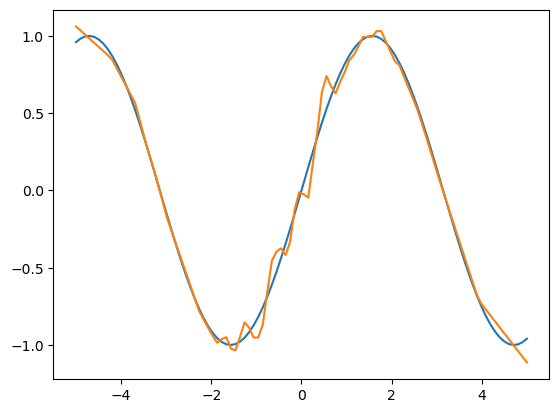

In [16]:
from math import isnan
import torch.nn as nn
from typing import Callable
from typing import Iterable, Any


def mean_squared_error(predictions: Tensor, targets: Tensor,):
    return ((predictions - targets) ** 2).mean()

# Note size is (input features, output features)
def init_params(size):
    return torch.randn(size, requires_grad=True)

hidden_neurons = 100
# Hidden layer weights/bias
w1 = init_params((1, hidden_neurons))
b1 = init_params(hidden_neurons)
# Ouput weights/bias
w2 = init_params((hidden_neurons, 1))
b2 = init_params(1)

# Note lack of validation set
x = torch.linspace(-5, 5, 100)
y = torch.sin(x)
dataset = list(zip(x.unsqueeze(1), torch.sin(x).unsqueeze(1)))
data_loader = DataLoader(dataset, batch_size=10)

def simple_net(xb: Tensor):
    # Hidden Layer 1 linear function
    res = xb@w1 + b1
    # Hidden Layer 1 nonlinear activation function
    res = res.max(tensor(0.))
    # Ouput layer linear function
    res = res@w2 + b2
    return res

def calc_grad(xb: Tensor, yb: Tensor, model: Callable[[Tensor], Tensor]):
    predictions = model(xb)
    loss = mean_squared_error(predictions, yb)
    loss.backward()

def train_epoch(
    model: Callable[[Tensor], Tensor],
    learning_rate: float,
    params: List[Tensor]
):
    for xb, yb in data_loader:
        calc_grad(xb, yb, model)
        for param in params:
            param.data -= param.grad * learning_rate
            param.grad.zero_()

def batch_accuracy(xb: Tensor, yb: Tensor):
    return mean_squared_error(xb, yb)
    # predictions = xb.sigmoid()
    # correct = (predictions > 0.5).float() == yb
    # return correct.float().mean()

def validate_epoch(model: Callable[[Tensor], Tensor]):
    accuracies = [batch_accuracy(model(xb), yb) for xb, yb in data_loader]
    return round(torch.stack(accuracies).mean().item(), 4)

def train_model(model, epochs):
    for epoch in range(epochs):
        train_epoch(model, 0.0001, [w1, b1, w2, b2])
        accuracy = validate_epoch(model)
        if epoch % 1000 == 0 or epoch == 0:
            print(accuracy, end=' ')

train_model(simple_net, 10000)

plt.plot(x, y)
# plt.title(f"MSE {round(loss_function(actual, prediction).item(), 3)}")
plt.plot(x, simple_net(x.unsqueeze(1)).detach().numpy())

### Update to use pytorch/fastai native

In [8]:
# Note lack of validation set
x = torch.linspace(-5, 5, 100)
y = torch.sin(x)
dataset = list(zip(x.unsqueeze(1), torch.sin(x).unsqueeze(1)))
data_loader = DataLoader(dataset, batch_size=10)


def mean_squared_error(predictions: Tensor, targets: Tensor,):
    return ((predictions - targets) ** 2).mean()
    
def batch_accuracy(xb: Tensor, yb: Tensor):
    return mean_squared_error(xb, yb)

def validate_epoch(model: Callable[[Tensor], Tensor]):
    accuracies = [batch_accuracy(model(xb), yb) for xb, yb in data_loader]
    return round(torch.stack(accuracies).mean().item(), 4)

simple_net_final = nn.Sequential(
    nn.Linear(1, 100),
    nn.ReLU(),
    nn.Linear(100, 1)
)

learn = Learner(
    DataLoaders(data_loader, data_loader),
    simple_net_final,
    opt_func=SGD,
    loss_func=mean_squared_error
    # metrics=batch_accuracy
)

with learn.no_logging():
    learn.fit(n_epoch=1000, lr=0.0001)
print(validate_epoch(simple_net_final))

0.0357


## MNSIT Project

In [6]:
path = untar_data(URLs.MNIST_SAMPLE)
path

Path('C:/Users/Danny/.fastai/data/mnist_sample')

In [7]:
threes = sorted([path for path in path.joinpath('train').joinpath('3').glob('*')])
sevens = sorted([path for path in path.joinpath('train').joinpath('7').glob('*')])
threes[:5]

[Path('C:/Users/Danny/.fastai/data/mnist_sample/train/3/10.png'),
 Path('C:/Users/Danny/.fastai/data/mnist_sample/train/3/10000.png'),
 Path('C:/Users/Danny/.fastai/data/mnist_sample/train/3/10011.png'),
 Path('C:/Users/Danny/.fastai/data/mnist_sample/train/3/10031.png'),
 Path('C:/Users/Danny/.fastai/data/mnist_sample/train/3/10034.png')]

In [122]:
from fastai.vision.all import *
matplotlib.rc('image', cmap='Greys')

In [123]:
# Note Image is from the Python Imaging Library (PIL)
three_image = Image.open(threes[1])
three_image

In [40]:
array(three_image)[:17,4:17]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29, 150, 195, 254, 255, 254, 176, 193],
       [  0,   0,   0,  48, 166, 224, 253, 253, 234, 196, 253, 253, 253],
       [  0,  93, 244, 249, 253, 187,  46,  10,   8,   4,  10, 194, 253],
       [  0, 107, 253, 253, 230,  48,   0,   0,   0,   0,   0, 192, 253],
       [  0,   3,  20,  20,  15,   0,   0,   0,   0,   0,  43, 224, 253],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 249, 253, 245],
       [  0,   0,   0,   0,   0,   0,   0,  14, 101, 223, 253, 248, 124],
       [  0,   0,   0,   0,   0,  11, 166, 239, 253, 253, 253, 187,  30],
       [  0,   0,   0,   0,   0,  16, 

In [124]:
three_image_tensor = tensor(three_image)
df = pd.DataFrame(three_image_tensor[4:17, 4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


In [126]:
threes_tensor = [tensor(Image.open(image_path)) for image_path in threes]
sevens_tensor = [tensor(Image.open(image_path)) for image_path in sevens]

In [49]:
threes_tensor[0].size()

torch.Size([28, 28])

In [140]:
# We now have an array of tensors, but we need it to be a 3d tensor instead
# Turn greyscale to 0 to 1
threes_tensor = torch.stack(threes_tensor).float() / 255
sevens_tensor = torch.stack(sevens_tensor).float() / 255
threes_tensor.size()

TypeError: stack(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

In [143]:
# combine both into 1 tensor
threes_sevens_tensor = torch.cat([threes_tensor, sevens_tensor])
threes_sevens_tensor.size()

torch.Size([12396, 28, 28])

In [145]:
# Simplify our tensor by smashing the rows together into a continuous array
# This makes it from a list of matrices to a list of vectors
# This is the shape of our final training tensor
total_pixels_per_image = 28*28
train_x = threes_sevens_tensor.view(-1,total_pixels_per_image)
# This is basically telling us we have 12,396 images (threes and sevens)
# Each of which have 784 pixels
train_x.size()
# len(train_x[0])

torch.Size([12396, 784])

In [12]:
# The labels for our data are simple - 1 for threes, 0 for sevens
# Also, make sure it has the same shape as the input data by unsqueezing
train_y = torch.cat([torch.ones(len(threes_tensor) - 1),
                    torch.zeros(len(sevens_tensor) - 1)]).unsqueeze_(1)
train_y.size()

torch.Size([12394, 1])

In [80]:
# Next, we need to create a dataset, which in pytorch is a tuple of (x,y)
# In other words, each image has its associated label in a tuple
dataset = list(zip(train_x, train_y))
x,y = dataset[0]
x.size(),y

(torch.Size([784]), tensor([1.]))

In [13]:
# Do the same for the validation set
threes_valid = sorted([path for path in path.joinpath('valid').joinpath('3').glob('*')])
sevens_valid = sorted([path for path in path.joinpath('valid').joinpath('7').glob('*')])
valid_3_tensor = torch.stack(
    [tensor(Image.open(image_path)) for image_path in threes_valid]
).float() / 255
valid_7_tensor = torch.stack(
    [tensor(Image.open(image_path)) for image_path in sevens_valid]
).float() / 255

valid_x = torch.cat([valid_3_tensor, valid_7_tensor]).view(-1, total_pixels_per_image)
valid_y = torch.cat([torch.ones(len(valid_3_tensor) - 1),
                    torch.zeros(len(valid_7_tensor) - 1)]).unsqueeze_(1)
valid_dataset = list(zip(valid_x, valid_y))

In [14]:
# Note size is (input features, output features)
def init_params(size):
    return torch.randn(size, requires_grad=True)

# Here we initialize a weight for each pixel in the image
weights = init_params((total_pixels_per_image, 1))
# One bias since we are only using 1 neuron
bias = init_params(1)

As with our simple continuous regression prediction function, creating a prediction is just a matter of multiplying the weights by the inputs (the pixels in the image) and adding the bias.

The only addition here is we are doing matrix multiplication (@ operator) to do the weight multiplication, which substantially increases efficiency.

We can also restrict the outputs of our model to between 0 and 1, where 1 is 100% sure it is a 3 and 0 being 100% sure it is 7 (and 0.2, for example, that we have high confidence it is a 7).

In [15]:
# Create a prediction for each image
# xb refers to a "batch" of x's (not the whole dataset)
def linear1(xb: Tensor):
    return xb@weights + bias

In [102]:
# Tensors and matrix multiplications make it incredibly fast to perform linear operations
# Here, we're performing 784 multiplications/additions (matrix multiplications) on 12,396 images nearly instantly to produce a prediction for each.
predictions = linear1(train_x)
predictions[5:20]

tensor([-13.4730, -12.9192,  -0.0726, -17.7874,  -2.9325,  -2.5538,   6.3558,
         -0.0607, -20.0962,   6.7785,   3.9525,  -5.3891,  -2.7368,  -5.4243,
          4.1245], grad_fn=<SliceBackward0>)

The last piece we need is the loss function.

We can't just use mean squared error - there is no "distance" in a classification problem (unless you use the "distance from mean 3/mean 7" option, which is not as scalable). However, we can't just use "label right" and "label wrong" as our loss function, because we won't have a meaningful gradient. We need to smooth it out - how close to right were we?

Thus, we can define the loss function as a scale of our "confidence" that our prediction is correct. So the loss scale is conceptually:

Largest loss -> smallest loss
* High confidence in a wrong answer
* Low confidence in a wrong answer
* Low confidence in a right answer
* High confidence in a right answer

In [26]:
def mnist_loss_simple_test(prediction: float, label: float):
    if label == 1:
        return label - prediction
    # If label is 0, then prediction - label is the same as just prediction
    # So we can save a ton of operations by not doing it
    else:
        return prediction

def mnist_loss(predictions: Tensor, targets: Tensor):
    predictions.sigmoid()
    return torch.where(targets == 1, 1 - predictions, predictions).mean()

We have everything we need to create our training loop now. However, one final important optimization is necessary to reflect real-world use.Currently, we have 12,000 images, and that's just 3's and 7's. If we used the same method as our continuous function, we'd be training 12k images on each epoch, and feeding all 12k in for training simultaneously before performing a loss function on them and updating the weights based on the gradient (*the optimization step*).

This is strictly the most accurate way to do it, but it can be extremely slow, and completely impractical for the very large datasets you see in the real world (think millions for the vision learners trained by google).

A good tradeoff between feeding the entire dataset before performing the optimization step and feeding individual images then performing the optimization step is the concept of mini-batches. We determine a batch size, then feed that amount of images in before performing the optimization step, doing the parameter adjustments, then feeding in the next batch. An "epoch" has elapsed when all batches in a full set of data have been seen. So if there are 120 images and batch size is 10, there are 12 batches in an epoch.

There is a tradeoff when determining batch size. 

Larger batch sizes give you more accurate and stable estimates of your dataset's gradients from the loss function, but take longer, and you process fewer mini-batches per epoch.

Additionally, GPUs are only useful in speeding up operations if they are given enough to do - in order for a GPU to perform work, we need to transfer data to its memory, which is an inefficient process. So, mini-batches make sure they have a good chunk of work to do so they ultimately save time, despite memory transfer costs. However, if your GPU memory is too low for a larger batch size, it will fail. So, you also have to work within the confines of your GPU's physical limitations.

One final consideration in batches is that we can improve the efficacy of batch training by randomizing the batches, so each epoch gets data in a slightly different way (similar to to concept of data augmentation improving performance and generalization - strech/smoosh/rotate images, etc).

In [113]:
# DataLoaders, provided by pytorch, do shuffling and mini-batch collation for you.
data_loader = DataLoader(range(15), batch_size=5, shuffle=True)
# Different order each time it is run
list(data_loader)

[tensor([ 0,  5, 13,  4,  3]),
 tensor([10,  1,  9,  8,  6]),
 tensor([14,  7, 12,  2, 11])]

In [116]:
# Further, we need our data to be tuples of prediction and label. When we're shuffling, we can no longer rely on stable array index order.
# This is where datasets come into play, tuples of x,y for each prediction
dataset = list(enumerate(string.ascii_lowercase))
dataset[:5]

[(0, 'a'), (1, 'b'), (2, 'c'), (3, 'd'), (4, 'e')]

In [118]:
# DataLoaders also automatically collate and shuffle datasets - tuples of the predictions and targets
data_loader = DataLoader(dataset, batch_size=6, shuffle=True)
list(data_loader)

[(tensor([12,  7, 19, 16, 11,  1]), ('m', 'h', 't', 'q', 'l', 'b')),
 (tensor([15, 24,  0, 22,  6, 10]), ('p', 'y', 'a', 'w', 'g', 'k')),
 (tensor([23, 13, 14, 25,  2, 20]), ('x', 'n', 'o', 'z', 'c', 'u')),
 (tensor([18,  9,  8,  4, 21, 17]), ('s', 'j', 'i', 'e', 'v', 'r')),
 (tensor([5, 3]), ('f', 'd'))]

While our loss function is exactly what we need to have a useful gradient, it's fairly meaningless with regard to how well the model is actually performing.

What we're ultimately looking for is the "accuracy" of the model, not some arbitrary distance from the correct answer. Thus, we just need to create a simple validation function which shows us our accuracy.

In [22]:
def batch_accuracy(xb: Tensor, yb: Tensor):
    predictions = xb.sigmoid()
    # Here we're just saying if the prediction is > 0.5, we're predicting a 3 (since 3 == 1 in our lingo), so we just turn anything > 0.5 into a 1
    # That 1 should match our label of 1 if it is actually a 3, else it's wrong
    correct = (predictions > 0.5).float() == yb
    # We can then transform this tensor into a single digit accuracy for the batch
    return correct.float().mean()

test_batch = train_x[:20]
test_batch_predictions = linear1(test_batch)
batch_accuracy(test_batch_predictions, train_y[:20])

tensor(0.8000)

In [34]:
# We can further validate a whole epoch by doing this for the entire validation set, which gives us our model's true accuracy on the validation set (not the training set)
valid_dataloader = DataLoader(valid_dataset, batch_size=256)
def validate_epoch(model: Callable[[Tensor], Tensor]):
    accuracies = [batch_accuracy(model(xb), yb) for xb, yb in valid_dataloader]
    return round(torch.stack(accuracies).mean().item(), 4)

validate_epoch(linear1)

0.5073

In [7]:
# All prep code in one block
path = untar_data(URLs.MNIST_SAMPLE)

threes = sorted([path for path in path.joinpath('train').joinpath('3').glob('*')])
sevens = sorted([path for path in path.joinpath('train').joinpath('7').glob('*')])
threes_tensor = torch.stack(
    [tensor(Image.open(image_path)) for image_path in threes]
).float() / 255
sevens_tensor = torch.stack(
    [tensor(Image.open(image_path)) for image_path in sevens]
).float() / 255

total_pixels_per_image = 28*28
train_x = torch.cat([threes_tensor, sevens_tensor]).view(-1, total_pixels_per_image)
train_y = torch.cat([torch.ones(len(threes_tensor) - 1).int(),
                    torch.zeros(len(sevens_tensor) - 1).int()]).unsqueeze_(1)

dataset = list(zip(train_x, train_y))
data_loader = DataLoader(dataset, batch_size=256)

threes_valid = sorted([path for path in path.joinpath('valid').joinpath('3').glob('*')])
sevens_valid = sorted([path for path in path.joinpath('valid').joinpath('7').glob('*')])
valid_3_tensor = torch.stack(
    [tensor(Image.open(image_path)) for image_path in threes_valid]
).float() / 255
valid_7_tensor = torch.stack(
    [tensor(Image.open(image_path)) for image_path in sevens_valid]
).float() / 255

valid_x = torch.cat([valid_3_tensor, valid_7_tensor]).view(-1, total_pixels_per_image)
valid_y = torch.cat([torch.ones(len(valid_3_tensor) - 1).int(),
                    torch.zeros(len(valid_7_tensor) - 1).int()]).unsqueeze_(1)

valid_dataset = list(zip(valid_x, valid_y))
valid_data_loader = DataLoader(valid_dataset, batch_size=256)

In [8]:
list(valid_data_loader)

[(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]),
  tensor([[1],
          [1],
          [1],
          [1],
          [1],
          [1],
          [1],
          [1],
          [1],
          [1],
          [1],
          [1],
          [1],
          [1],
          [1],
          [1],
          [1],
          [1],
          [1],
          [1],
          [1],
          [1],
          [1],
          [1],
          [1],
          [1],
          [1],
          [1],
          [1],
          [1],
          [1],
          [1],
          [1],
          [1],
          [1],
          [1],
          [1],
          [1],
          [1],
          [1],
          [1],
          [1],
          [1],
          [1],
          [1],
          [1],
          [1],
          [1],
          [

In [12]:
# Putting it all together in one block to digest

def init_params(size: int):
    return torch.randn(size, requires_grad=True)

weights = init_params(total_pixels_per_image)
bias = init_params(1)

def linear1(xb: Tensor):
    return xb@weights + bias

def mnist_loss(predictions: Tensor, targets: Tensor):
    predictions = predictions.sigmoid()
    return torch.where(targets == 1, 1 - predictions, predictions).mean()

def calc_grad(xb: Tensor, yb: Tensor, model: Callable[[Tensor], Tensor]):
    predictions = model(xb)
    loss = mnist_loss(predictions, yb)
    loss.backward()

def train_epoch(
    model: Callable[[Tensor], Tensor],
    learning_rate: float,
    params: tuple[Tensor, Tensor]
):
    for xb, yb in data_loader:
        calc_grad(xb, yb, model)
        for param in params:
            param.data -= param.grad * learning_rate
            param.grad.zero_()

def batch_accuracy(xb: Tensor, yb: Tensor):
    predictions = xb.sigmoid()
    correct = (predictions > 0.5).float() == yb
    return correct.float().mean()

def validate_epoch(model: Callable[[Tensor], Tensor]):
    accuracies = [batch_accuracy(model(xb), yb) for xb, yb in valid_data_loader]
    return round(torch.stack(accuracies).mean().item(), 4)

def train_model(model, epochs):
    for epoch in range(epochs):
        params = weights, bias
        train_epoch(model, 1., params)
        accuracy = validate_epoch(linear1)
        print(accuracy, end=' ')

train_model(linear1, 20)

0.6695 0.833 0.8974 0.9183 0.9336 0.9411 0.9449 0.9463 0.9473 0.9495 0.9523 0.9537 0.9555 0.9555 0.956 0.957 0.9575 0.9585 0.9585 0.959 

In [16]:
# Redo using built-in pytorch/fastai functions that do the same thing

# def init_params(size: int):
#     return torch.randn(size, requires_grad=True)

# weights = init_params(total_pixels_per_image)
# bias = init_params(1)

# def linear1(xb: Tensor):
#     return xb@weights + bias

# All of the above can be expressed as nn.Linear
# This contains both the init_params and the linear together
# linear_model.paramaters() gives you the weights and biases
linear_model = nn.Linear(28*28, 1)

def mnist_loss(predictions: Tensor, targets: Tensor):
    predictions = predictions.sigmoid()
    return torch.where(targets == 1, 1 - predictions, predictions).mean()

def calc_grad(xb: Tensor, yb: Tensor, model: Callable[[Tensor], Tensor]):
    predictions = model(xb)
    loss = mnist_loss(predictions, yb)
    loss.backward()

class BasicOptimiser:
    def __init__(self, params: Iterator[Tensor], learning_rate: float):
        self.params = list(params)
        self.learning_rate = learning_rate

    def step(self, *args, **kwargs):
        for param in self.params:
            param.data -= param.grad.data * self.learning_rate

    def zero_grad(self, *args, **kwargs):
        for param in self.params:
            param.grad = None

# The optimiser is the step that handles SGD
# That basically just replaces incrementing the params by grad and zeroing it
# optimiser = BasicOptimiser(linear_model.parameters(), 1.)

# Further, we can simply use SGD, provided by fastai
optimiser = SGD(linear_model.parameters(), 1.)

def train_epoch(
    model: Callable[[Tensor], Tensor]
):
    for xb, yb in data_loader:
        calc_grad(xb, yb, model)
        optimiser.step()
        optimiser.zero_grad()
        # for param in params:
        #     param.data -= param.grad * learning_rate
        #     param.grad.zero_()

def batch_accuracy(xb: Tensor, yb: Tensor):
    predictions = xb.sigmoid()
    correct = (predictions > 0.5).float() == yb
    return correct.float().mean()

def validate_epoch(model: Callable[[Tensor], Tensor]):
    accuracies = [batch_accuracy(model(xb), yb) for xb, yb in valid_data_loader]
    return round(torch.stack(accuracies).mean().item(), 4)

def train_model(model, epochs):
    for epoch in range(epochs):
        params = weights, bias
        train_epoch(model, 1., params)
        accuracy = validate_epoch(linear1)
        print(accuracy, end=' ')

# train_model(linear1, 20)
# Instead of train_model, we can also use a Learner, which has learner.fit
learn = Learner(DataLoaders(data_loader, valid_data_loader), linear_model,
    opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)

learn.fit(n_epoch=10, lr=1.)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.637102,0.503706,0.495580,00:00
1,0.628657,0.294933,0.713654,00:00
2,0.229571,0.308032,0.686641,00:00
3,0.099216,0.143149,0.872790,00:00
4,0.050606,0.094008,0.919450,00:00
5,0.031722,0.071772,0.937623,00:00
6,0.023929,0.058992,0.949902,00:00
7,0.020485,0.050785,0.958743,00:00
8,0.018787,0.045205,0.963163,00:00
9,0.017811,0.041218,0.965128,00:00


In [17]:
# Final pytorch/fastai native function

def mnist_loss(predictions: Tensor, targets: Tensor):
    predictions = predictions.sigmoid()
    return torch.where(targets == 1, 1 - predictions, predictions).mean()

def batch_accuracy(xb: Tensor, yb: Tensor):
    predictions = xb.sigmoid()
    correct = (predictions > 0.5).float() == yb
    return correct.float().mean()

learn = Learner(
    DataLoaders(data_loader, valid_data_loader),
    nn.Linear(28*28, 1),
    opt_func=SGD,
    loss_func=mnist_loss,
    metrics=batch_accuracy
)

learn.fit(n_epoch=10, lr=1.)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.637244,0.503639,0.495580,00:00
1,0.602099,0.099449,0.936641,00:00
2,0.217356,0.229143,0.785363,00:00
3,0.093732,0.119805,0.900295,00:00
4,0.048165,0.083934,0.928291,00:00
5,0.030476,0.066082,0.944499,00:00
6,0.023255,0.055314,0.954322,00:00
7,0.020097,0.048254,0.960216,00:00
8,0.018540,0.043356,0.964637,00:00
9,0.017635,0.039787,0.966110,00:00


Final accuracy: 0.9813359379768372


Text(0, 0.5, 'Accuracy')

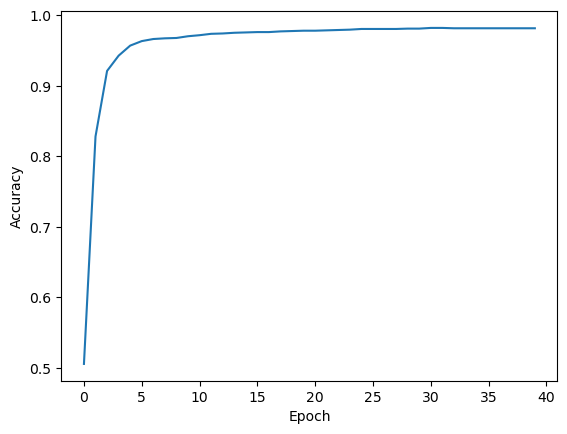

In [6]:
# Upgrade from a simple linear model to a simple neural net

def mnist_loss(predictions: Tensor, targets: Tensor):
    # predictions = predictions.sigmoid()
    return torch.where(targets == 1, 1 - predictions, predictions).mean()

def batch_accuracy(xb: Tensor, yb: Tensor):
    # predictions = xb.sigmoid()
    correct = (xb > 0.5).float() == yb
    return correct.float().mean()

hidden_neurons = 30

learn = Learner(
    DataLoaders(data_loader, valid_data_loader),
    nn.Sequential(
        nn.Linear(total_pixels_per_image, hidden_neurons),
        nn.ReLU(),
        nn.Linear(hidden_neurons, 1),
        nn.Sigmoid()
    ),
    opt_func=SGD,
    loss_func=mnist_loss,
    metrics=batch_accuracy
)

with learn.no_logging():
    learn.fit(n_epoch=40, lr=0.1)

print(f"Final accuracy: {learn.recorder.values[-1][2]}")
plt.plot(range(len(learn.recorder.values)), array(learn.recorder.values)[:, 2:])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [57]:
# Everything we did from scratch above, encompased in 7 lines of code
# With a resulting accuracy of 99.5% due to use of a more sophisticated neural net (resnet18)
path = untar_data(URLs.MNIST_SAMPLE)
dls = ImageDataLoaders.from_folder(path)
learn = vision_learner(
    dls, resnet18, pretrained=False, loss_func=F.cross_entropy, metrics=accuracy
)
learn.fit_one_cycle(1, 0.1)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


c:\Users\Danny\miniconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\Danny\miniconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,time
0,0.160287,0.047846,0.995093,00:52


TODO:
1. Create my own implementation of Learner from scratch
2. Recreate the titanic dataset solution using python neural net (with blog post visualising matmul?)
3. Complete the mnist dataset project to predict all images (not just 3 vs 7)

In [13]:
# https://github.com/NVIDIA/DIGITS/blob/master/digits/download_data/mnist.py
# Simple code to dl and unpack the mnist dataset from its official site:
# http://yann.lecun.com/exdb/mnist/

import gzip
import os
import shutil
import urllib.request
import struct

class MnistDownloader:
    """
    See details about the MNIST dataset here:
    http://yann.lecun.com/exdb/mnist/
    """

    def __init__(self, outdir, clean=False, file_extension='png') -> None:
        self.outdir = outdir
        self.mkdir(self.outdir, clean=clean)
        self.file_extension = file_extension.lower()

    def getData(self, skip_download=False):
        """
        This is the main function that should be called by the users!
        Downloads the dataset and prepares it for DIGITS consumption
        """

        if not skip_download:
            for url in self.urlList():
                self.__downloadFile(url)

        self.uncompressData()

        self.processData()
        print("Dataset directory is created successfully at '%s'" % self.outdir)

    def __downloadFile(self, url):
        """
        Downloads the url
        """
        download_path = os.path.join(self.outdir, os.path.basename(url))
        if not os.path.exists(download_path):
            print("Downloading url=%s ..." % url)
            urllib.request.urlretrieve(url, download_path)

    def mkdir(self, d, clean=False):
        """
        Safely create a directory
        Arguments:
        d -- the directory name
        Keyword arguments:
        clean -- if True and the directory already exists, it will be deleted and recreated
        """
        if os.path.exists(d):
            if clean:
                shutil.rmtree(d)
            else:
                return
        os.mkdir(d)

    def urlList(self):
        return [
            'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
            'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
            'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
            'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz',
        ]

    def uncompressData(self):
        for zipped, unzipped in [
                ('train-images-idx3-ubyte.gz',  'train-images.bin'),
                ('train-labels-idx1-ubyte.gz',  'train-labels.bin'),
                ('t10k-images-idx3-ubyte.gz',   'test-images.bin'),
                ('t10k-labels-idx1-ubyte.gz',   'test-labels.bin'),
        ]:
            zipped_path = os.path.join(self.outdir, zipped)
            assert os.path.exists(zipped_path), 'Expected "%s" to exist' % zipped
            unzipped_path = os.path.join(self.outdir, unzipped)
            if not os.path.exists(unzipped_path):
                print("Uncompressing file=%s ..." % zipped)
                with gzip.open(zipped_path) as infile, open(unzipped_path, 'wb') as outfile:
                    outfile.write(infile.read())

    def processData(self):
        self.__extract_images('train-images.bin', 'train-labels.bin', 'train')
        self.__extract_images('test-images.bin', 'test-labels.bin', 'test')

    def __extract_images(self, images_file, labels_file, phase):
        """
        Extract information from binary files and store them as images
        """
        labels = self.__readLabels(os.path.join(self.outdir, labels_file))
        images = self.__readImages(os.path.join(self.outdir, images_file))
        assert len(labels) == len(images), '%d != %d' % (len(labels), len(images))

        output_dir = os.path.join(self.outdir, phase)
        self.mkdir(output_dir, clean=True)
        with open(os.path.join(output_dir, 'labels.txt'), 'w') as outfile:
            for label in range(10):
                outfile.write('%s\n' % label)
        with open(os.path.join(output_dir, '%s.txt' % phase), 'w') as outfile:
            for index, image in enumerate(images):
                dirname = os.path.join(output_dir, labels[index])
                self.mkdir(dirname)
                filename = os.path.join(dirname, '%05d.%s' % (index, self.file_extension))
                image.save(filename)
                outfile.write('%s %s\n' % (filename, labels[index]))

    def __readLabels(self, filename):
        """
        Returns a list of ints
        """
        print('Reading labels from %s ...' % filename)
        labels = []
        with open(filename, 'rb') as infile:
            infile.read(4)  # ignore magic number
            count = struct.unpack('>i', infile.read(4))[0]
            data = infile.read(count)
            for byte in data:
                label = struct.unpack('>B', byte.to_bytes(1, sys.byteorder))[0]
                labels.append(str(label))
        return labels

    def __readImages(self, filename):
        """
        Returns a list of PIL.Image objects
        """
        print('Reading images from %s ...' % filename)
        images = []
        with open(filename, 'rb') as infile:
            infile.read(4)  # ignore magic number
            count = struct.unpack('>i', infile.read(4))[0]
            rows = struct.unpack('>i', infile.read(4))[0]
            columns = struct.unpack('>i', infile.read(4))[0]

            for i in range(count):
                data = infile.read(rows * columns)
                image = np.fromstring(data, dtype=np.uint8)
                image = image.reshape((rows, columns))
                image = 255 - image  # now black digit on white background
                images.append(Image.fromarray(image))
        return images

mnist_dl = MnistDownloader(
    outdir=r"C:\Users\Danny\ml_datasets\mnist"
)

mnist_dl.getData(skip_download=True)

Reading labels from C:\Coding\Data Science\fastai\course22\datasets\mnist\train-labels.bin ...
Reading images from C:\Coding\Data Science\fastai\course22\datasets\mnist\train-images.bin ...


C:\Users\Danny\AppData\Local\Temp\ipykernel_25148\3812434671.py:138: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  image = np.fromstring(data, dtype=np.uint8)


Reading labels from C:\Coding\Data Science\fastai\course22\datasets\mnist\test-labels.bin ...
Reading images from C:\Coding\Data Science\fastai\course22\datasets\mnist\test-images.bin ...
Dataset directory is created successfully at 'C:\Coding\Data Science\fastai\course22\datasets\mnist'


In [15]:
from sklearn.model_selection import train_test_split

def get_image_data_loader(base_path: Path):
    """Create data_loader for a directory of images.

    Note: Expects folder names to be label names of the images contained

    Args:
        base_path:
    """
    label_images_tensors: List[Tensor] = []
    labels_tensors: List[Tensor] = []
    for idx, label_path in enumerate(base_path.glob('*')):
        # For each image in the label's folder:
        #   Open the image and make it a tensor
        #   Stack the array of images into a tensor
        #   Convert grayscale values 0-255 to a 0-1 scale
        images_tensor = torch.stack(
                [tensor(Image.open(image_path)) for image_path in label_path.glob('*')]
            ).float() / 255
        label_images_tensors.append(images_tensor)
        # Create an integer label for each label
        labels_tensors.append(
            (torch.zeros(len(images_tensor) - 1) + idx).int()
        )
    
    # Concatenate all the image tensors of all the labels into 1 tensor
    # Smash the 28x28 matrix of pixels into a single vector of 784 pixels
    x = torch.cat(label_images_tensors).view(-1, 28*28)
    # Mirror the shape of the input data by unsqueezing
    # (making a bunch of scalars into arrays with a single item)
    y = torch.cat(labels_tensors).unsqueeze_(1)

    x_train, x_valid, y_train, y_valid = train_test_split(
        x, y, test_size=0.1, random_state=42
    )

    return DataLoader(list(zip(x_train, y_train)), batch_size=256), DataLoader(list(zip(x_valid, y_valid)), batch_size=256)

In [38]:
# Seems to work, but is terribly slow (stopped at 4 minutes)
# full_mnist_train_data_loader, full_mnist_valid_data_loader = get_image_data_loader(Path(r"C:\Users\Danny\ml_datasets\mnist\train"))

full_mnist_data_loaders = ImageDataLoaders.from_folder(
    Path(r"C:\Users\Danny\ml_datasets\mnist"),
    valid_pct=0.1,
    verbose=True,
    bs=256
)


Found 70000 items
2 datasets of sizes 63000,7000
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Setting up after_item: Pipeline: ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}


In [39]:
train_test = full_mnist_data_loaders.train_ds[:3]
valid_test = full_mnist_data_loaders.valid_ds[:3]

In [40]:
train_test

[(PILImage mode=RGB size=28x28, TensorCategory(8)),
 (PILImage mode=RGB size=28x28, TensorCategory(4)),
 (PILImage mode=RGB size=28x28, TensorCategory(9))]

In [41]:
valid_test

[(PILImage mode=RGB size=28x28, TensorCategory(5)),
 (PILImage mode=RGB size=28x28, TensorCategory(4)),
 (PILImage mode=RGB size=28x28, TensorCategory(1))]

In [42]:
train_test[0][0]

In [103]:
import os
from typing import Any
from pathlib import Path

import pandas as pd
from torch.utils.data import Dataset, random_split
from torchvision.io import read_image


class MNISTImageDataset(Dataset):
    def __init__(self, annotations_file: Path, img_dir: Path, transform: Any=None, target_transform: Any=None):
        self.img_labels = pd.read_csv(annotations_file, header=None, delimiter=' ')
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx: int):
        file_name = self.img_labels.iloc[idx, 0]
        label = self.img_labels.iloc[idx, 1]
        img_path = self.img_dir.joinpath(str(label)).joinpath(str(file_name))
        image = read_image(str(img_path)).float() / 255
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [117]:
import torchvision

num_labels = 10 # 0 through 9 are the labels

mnist_dataset = MNISTImageDataset(
    annotations_file=Path(r"C:\Users\Danny\ml_datasets\mnist\train\train.txt"),
        img_dir=Path(r"C:\Users\Danny\ml_datasets\mnist\train"),
    # one-hot encode the label (so a 6 turns to tensor 0,0,0,0,0,0,1,0,0,0)
    target_transform=Lambda(lambda y: torch.zeros(num_labels, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))
)
# mnist_dataset.img_labels.iloc[2, 0]

training_num, validation_num = math.floor(0.9 * len(mnist_dataset)), math.floor(0.1 * len(mnist_dataset))
training_num = training_num + (len(mnist_dataset) - (training_num + validation_num))

mnist_dataset_training, mnist_dataset_validation = random_split(
    mnist_dataset,
    [training_num, validation_num],
    generator=torch.Generator().manual_seed(42)
)

In [115]:
len(mnist_dataset_training), len(mnist_dataset_validation)

(54000, 6000)

In [116]:
image, label = mnist_dataset_training[2]
label

tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

In [87]:
import torch.utils.data

train_loader = torch.utils.data.DataLoader(
    mnist_dataset_training,
    batch_size=256
)
valid_loader = torch.utils.data.DataLoader(
    mnist_dataset_validation,
    batch_size=256
)

Feature batch shape: torch.Size([256, 1, 28, 28])
Labels batch shape: torch.Size([256])


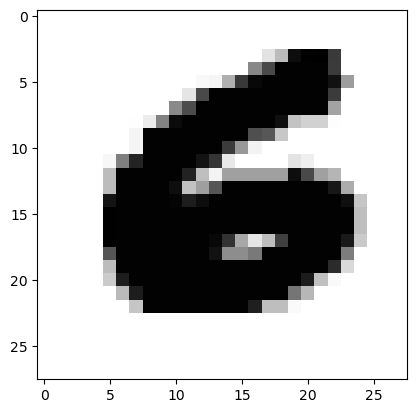

Label: 6
torch.Size([28, 28])


In [97]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
plt.imshow(img, cmap='gray')
plt.show()
label = train_labels[0]
print(f"Label: {label}")
print(train_features[0].squeeze().shape)

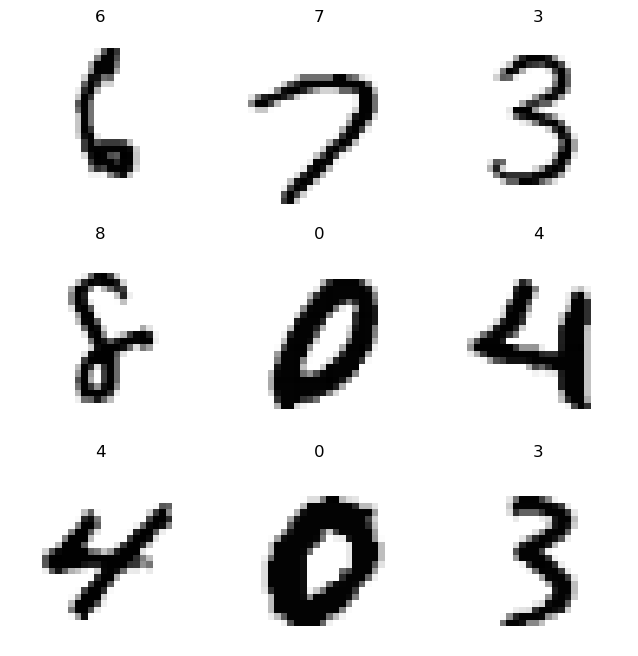

In [112]:
figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(mnist_dataset_training), size=(1,)).item()
    img, label = mnist_dataset_training[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

In [118]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [147]:
# https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

class NeuralNetwork(nn.Module):
    def __init__(self) -> None:
        super(NeuralNetwork, self).__init__()
        # This does exactly what .view(-1, total_pixels_image) does -
        # This makes it from a list of 28x28 matrices
        #   to a list of vectors of 784 pixels
        # This is required because the linear function
        # operates on a single array (x@w)
        self.flatten = nn.Flatten()
        total_pixels_per_image = 28*28
        hidden_neurons = 30
        total_labels = 10 # 0 through 9 are the labels
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(total_pixels_per_image, hidden_neurons),
            nn.ReLU(),
            nn.Linear(hidden_neurons, total_labels),
        )

    def forward(self, x: Tensor):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [159]:
model = NeuralNetwork().to(device)
print('Model Structure:')
print(model)

Model Structure:
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=10, bias=True)
  )
)


In [161]:
print('Model parameters (weights and biases)\n==============\n')
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values: {param[:2]} \n")

Model parameters (weights and biases)

Layer: linear_relu_stack.0.weight | Size: torch.Size([30, 784]) | Values: tensor([[ 0.0235, -0.0109,  0.0015,  ..., -0.0068,  0.0275,  0.0174],
        [-0.0213, -0.0087, -0.0160,  ...,  0.0082,  0.0173,  0.0053]],
       device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([30]) | Values: tensor([0.0220, 0.0052], device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([10, 30]) | Values: tensor([[-8.0140e-02,  4.7712e-02,  1.2509e-01, -1.3166e-01,  1.5895e-04,
         -1.7818e-01,  2.1297e-02,  2.7739e-02, -2.2577e-02, -5.4631e-02,
          6.8621e-04, -1.2339e-01,  3.9027e-02,  1.7383e-01, -7.0485e-02,
         -1.2674e-01, -1.1772e-01,  1.4992e-01,  1.7936e-01, -7.7114e-02,
          1.1007e-01, -4.7514e-02, -4.0870e-02, -1.0792e-02, -1.3693e-01,
          1.1904e-01, -1.3828e-01,  1.4250e-01, -5.9598e-02,  6.1356e-02],
        [-1.7488e-01,  4.2181e-02,  1.5

In [154]:
X_test = torch.rand(1, 28, 28, device=device)
logits = model(X_test)
# Logits is the raw prediction for each label
print(logits)

tensor([[-0.2220, -0.2140,  0.1225, -0.1086, -0.1183, -0.0132,  0.1475,  0.0251,
          0.0724,  0.1221]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [155]:
y_pred_test: Tensor = nn.Softmax(dim=1)(logits)
# Softmax normalizes each raw prediction to a probability for each class/label
# All of which add up to 1 total
print(y_pred_test, y_pred_test.sum())

tensor([[0.0809, 0.0815, 0.1142, 0.0906, 0.0897, 0.0997, 0.1171, 0.1036, 0.1086,
         0.1141]], device='cuda:0', grad_fn=<SoftmaxBackward0>) tensor(1., device='cuda:0', grad_fn=<SumBackward0>)


In [158]:
predicted_number = y_pred_test.argmax(1)
# argmax just grabs the highest probability number
# Which tells us the actual prediction
print(predicted_number)

tensor([6], device='cuda:0')
